# scikit-learn: from zero to hero!

Author : Alexandre Gramfort <alexandre.gramfort@inria.fr>

Powered by the [scikit-learn](http://scikit-learn.org)

License : BSD 3 clause

First, load the scikit-learn package:

In [1]:
import sklearn

Filter warnings and import matplotlib

In [2]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 9, 6
plt.rcParams['font.size'] = 16

import warnings  # Hide all warnings here
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Loading digits dataset

scikit-learn gives simple access to [public datasets](http://scikit-learn.org/stable/datasets/index.html)

In [3]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target
print(X.shape)   # contains 1797 images of 64 pixels
print(y.shape)
print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


Let's look at some images

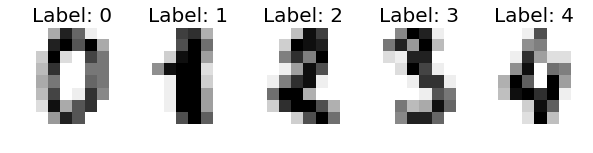

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for ax, (i, x) in zip(axes, enumerate(X[:5])):
    img = x.reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i' % y[i], fontsize=20)
    ax.axis('off')

## Supervised learning: Classification

Objective: learn model that can predict digit from image

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state=42)  # split data in train and test
classifier = SVC()  # instanciate model
classifier.fit(X_train, y_train)  # learning
y_pred = classifier.predict(X_test)  # prediction

In [6]:
print(y_test[:4], y_pred[:4])

[6 9 3 7] [6 3 3 7]


Let's visualize the prediction:

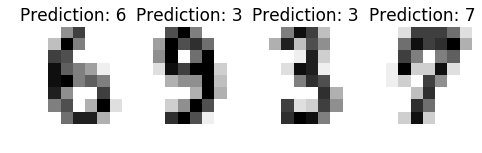

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(8, 4))
for ax, (i, x) in zip(axes, enumerate(X_test[:5])):
    img = x.reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % y_pred[i], fontsize=17)
    ax.axis('off')

## Dimensionality reduction

Go from dimension 64 to 2 to visualize/compress/understand data

In [8]:
from matplotlib import offsetbox

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

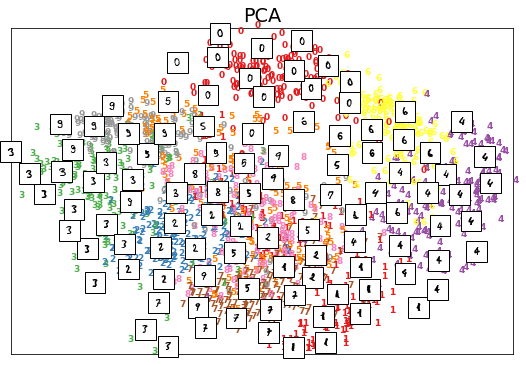

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Using Principal Component Analysis
X_pca = pca.fit_transform(X)
plot_embedding(X_pca, "PCA")

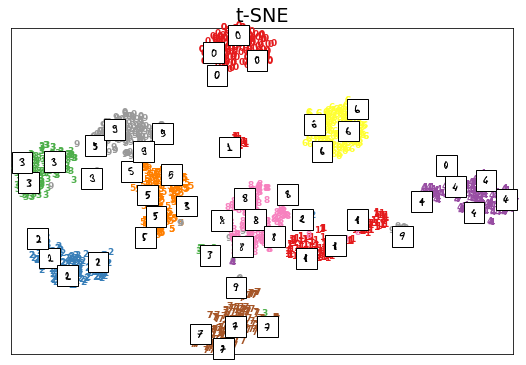

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, "t-SNE")

### Unsupervised anomaly detection

Objective: Identify the digits that look "different"

Assumption: anomalies are very rare

In [11]:
X_5 = X[y == 5]  # focus on the 5s

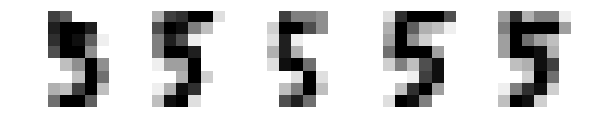

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for ax, x in zip(axes, X_5[:5]):
    img = x.reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

### Use Isolation Forest

In [13]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.05)
iforest = iforest.fit(X_5)

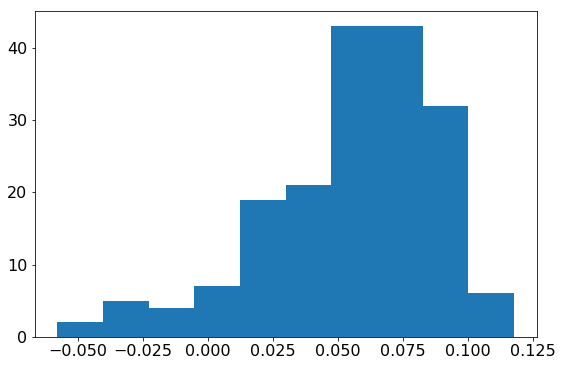

In [14]:
abnormality_score = iforest.decision_function(X_5)
plt.hist(abnormality_score);  # anomaly = low score

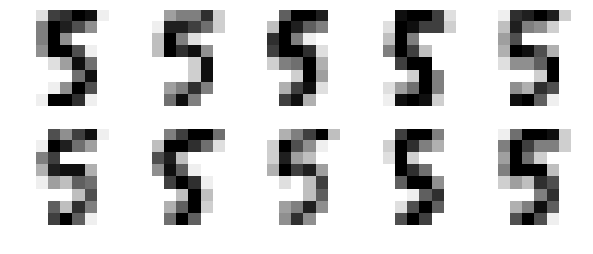

In [15]:
X_strong_inliers = X_5[np.argsort(abnormality_score)[-10:]]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in zip(range(len(X_strong_inliers)), axes.ravel()):
    ax.imshow(X_strong_inliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

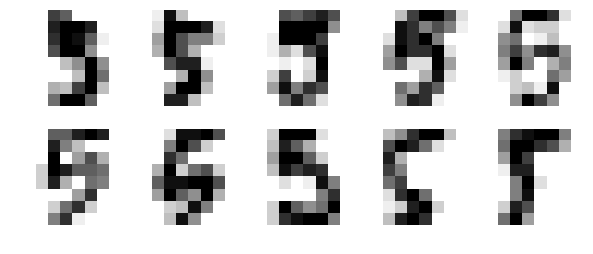

In [16]:
X_outliers = X_5[iforest.predict(X_5) == -1]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in zip(range(len(X_outliers)), axes.ravel()):
    ax.imshow(X_outliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

## Clustering

Objective: Regroup samples than are "similar"

We will work with a picture.

In [17]:
from sklearn.datasets import load_sample_image
# Load the Summer Palace photo
china = load_sample_image("china.jpg")
# Convert to floats in [0, 1]
china = np.array(china, dtype=np.float64) / 255
china.shape  # height, width, nb of colors

(427, 640, 3)

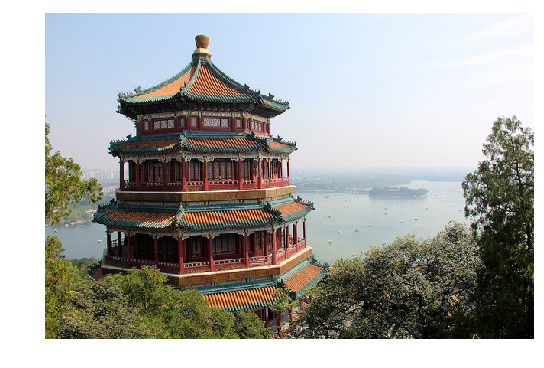

In [18]:
plt.imshow(china)
plt.axis('off');

**Objective:** regroup pixels with similar color

Let's format data for machine learning (n_samples, n_features)

**Idea:** One pixel is one sample in dimension 3

In [19]:
w, h, d = china.shape
X = np.reshape(china, (w * h, d))
print(X.shape)

(273280, 3)


In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, random_state=0)
kmeans.fit(X)
labels = kmeans.predict(X)
print(labels.shape)

(273280,)


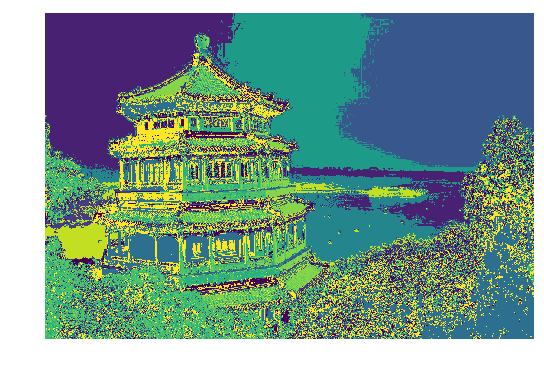

In [21]:
plt.imshow(labels.reshape(w, h))
plt.axis('off');

# Thanks

Contact me:

* GitHub [@agramfort](http://www.github.com/agramfort)
* Twitter [@agramfort](http://www.twitter.com/agramfort)